In [1]:
from TSInterpret.data import load_data
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
from ClassificationModels.LSTM_T import LSTM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import os 
from tslearn.datasets import UCR_UEA_datasets

# Parameters

In [2]:
#dataset='GunPoint'f
dataset='BasicMotions'

# Load Data

In [3]:
#TODO include OneHot Encoding Options
#train_x,test_x, train_y, test_y = load_data.load_basic_dataset(dataset,scaling=None,mode='time',cwd='/media/jacqueline/Data/UCRArchive_2018/')
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)

In [4]:
train_x.shape

(40, 100, 6)

In [5]:
print(test_y.shape)

(40,)


In [6]:
#enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
#pickle.dump(enc1,open(f'./ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
pickle.dump(enc1,open(f'../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))
    
#enc1=pickle.load(open(f'./ClassificationModels/models/{dataset}/OneHotEncoder.pkl','rb'))
#train_y=enc1.transform(train_y.reshape(-1,1))
#test_y=enc1.transform(test_y.reshape(-1,1))
    

# Model Training

In [7]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
device='cpu'
hidden_size=10
rnn=0.1
model = LSTM(6, hidden_size ,n_pred_classes,rnndropout=rnn).to(device)
fit(model,train_loader,test_loader)
if dataset in os.listdir('../ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'../ClassificationModels/models/{dataset}')
torch.save(model.state_dict(), f'../ClassificationModels/models/{dataset}/LSTM')
#model.load_state_dict(torch.load(f'./ClassificationModels/models/{dataset}/ResNet'))
#model.eval()

test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)

sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, test_preds)
sns.heatmap(heatmap, annot=True)
plt.savefig(f'../ClassificationModels/models/{dataset}/LSTM_confusion_matrix.png')
plt.close()
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'../ClassificationModels/models/{dataset}/LSTMclassification_report.csv', index = False)

Epoch: 1, Train loss: 1.386, Val loss: 1.395
Epoch: 2, Train loss: 1.382, Val loss: 1.393
Epoch: 3, Train loss: 1.38, Val loss: 1.392
Epoch: 4, Train loss: 1.375, Val loss: 1.39
Epoch: 5, Train loss: 1.375, Val loss: 1.388
Epoch: 6, Train loss: 1.372, Val loss: 1.386
Epoch: 7, Train loss: 1.372, Val loss: 1.385
Epoch: 8, Train loss: 1.367, Val loss: 1.383
Epoch: 9, Train loss: 1.36, Val loss: 1.381
Epoch: 10, Train loss: 1.359, Val loss: 1.38
Epoch: 11, Train loss: 1.351, Val loss: 1.378
Epoch: 12, Train loss: 1.353, Val loss: 1.376
Epoch: 13, Train loss: 1.355, Val loss: 1.374
Epoch: 14, Train loss: 1.344, Val loss: 1.373
Epoch: 15, Train loss: 1.337, Val loss: 1.371
Epoch: 16, Train loss: 1.343, Val loss: 1.369
Epoch: 17, Train loss: 1.344, Val loss: 1.367
Epoch: 18, Train loss: 1.34, Val loss: 1.365
Epoch: 19, Train loss: 1.334, Val loss: 1.364
Epoch: 20, Train loss: 1.338, Val loss: 1.362
Epoch: 21, Train loss: 1.338, Val loss: 1.36
Epoch: 22, Train loss: 1.322, Val loss: 1.358
Epo

# Explanation Algo

In [8]:
item=test_x[0].reshape(1,-1,6)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
y_target= model(_item).detach().numpy()
#y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

In [9]:
from TSInterpret.InterpretabilityModels.Saliency.SaliencyMethods_PTY import Saliency_PTY
int_mod=Saliency_PTY(model, train_x.shape[-1],train_x.shape[-2], method='IG', mode ='time')

2022-06-14 09:41:14.732760: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/cv2/../../lib64:
2022-06-14 09:41:14.732778: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
print(test_x[0,:,:].shape)
np.argmax(y_target,axis=1)[0] 

(100, 6)


2

In [11]:
exp=int_mod.explain(np.array([test_x[0,:,:]]),labels =1 ,TSR = True)

TypeError: 'str' object cannot be interpreted as an integer

In [ ]:
exp.shape

(100, 6)

In [ ]:
int_mod.plot(np.array([test_x[0,:,:]]),exp)

AttributeError: 'Saliency_PTY' object has no attribute 'mode'

time mode
(1, 100, 6)
(1, 6, 100)
(100, 6)
(6, 100)


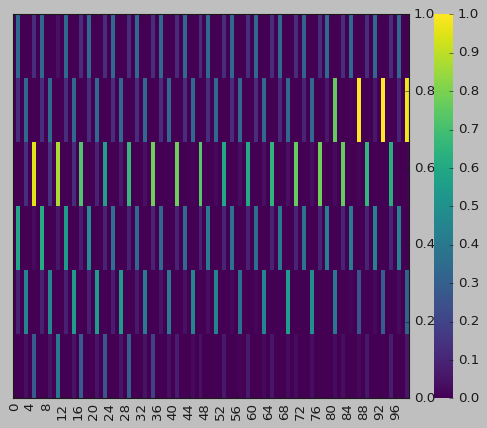

In [ ]:
int_mod.plot(np.array([test_x[0,:,:]]),exp, heatmap = True)